## makemore: part 5

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [29]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [21]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

................ --> y
...............y --> u
..............yu --> h
.............yuh --> e
............yuhe --> n
...........yuhen --> g
..........yuheng --> .
................ --> d
...............d --> i
..............di --> o
.............dio --> n
............dion --> d
...........diond --> r
..........diondr --> e
.........diondre --> .
................ --> x
...............x --> a
..............xa --> v
.............xav --> i
............xavi --> e


In [163]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    #self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.weight = nn.Parameter(torch.empty(fan_in, fan_out))
    nn.init.xavier_uniform_(self.weight) # note: xavier init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class ReLU:
  def __call__(self, x):
    self.out = torch.max(torch.tensor(0.0), x)
    return self.out
  
  def parameters(self):
    return []
  
# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    #self.weight = torch.randn((num_embeddings, embedding_dim))
    self.weight = nn.Parameter(torch.empty(num_embeddings, embedding_dim))
    nn.init.uniform_(self.weight, -0.5, 0.5)
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]


In [178]:
torch.manual_seed(42); # seed rng for reproducibility

In [179]:
# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), ReLU(), #Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), ReLU(), #Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), ReLU(), #Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [180]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
lossi_val = []
reg = 1e-4
m_prev = {id(p): torch.zeros_like(p) for p in parameters}  # First moment
v_prev = {id(p): torch.zeros_like(p) for p in parameters}  # Second 
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
max_norm = 2.0

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  for layer in model.layers:
    if(isinstance(layer, Linear)):
      loss += reg * torch.sum(layer.weight.data ** 2)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  with torch.no_grad():
    vix = torch.randint(0, Xdev.shape[0], (batch_size,))
    Xbv, Ybv = Xdev[vix], Ydev[vix]
    logits_val = model(Xbv)
    loss_val = F.cross_entropy(logits_val, Ybv)
  
  # update: simple SGD
  #lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  if i < 40000:
    lr = 1e-3
  elif i < 80000:
    lr = 1e-4
  else:
    lr = 1e-5

  for p in parameters:
    #p.data += -lr * p.grad
    # -------- adam optimizer --------
    t = i+1
    torch.nn.utils.clip_grad_norm_(parameters, max_norm)
    m_next = beta1*m_prev[id(p)] + + (1-beta1)*p.grad
    v_next = beta2*v_prev[id(p)] + + (1-beta2)*p.grad**2

    # Update moments
    m_prev[id(p)] = m_next
    v_prev[id(p)] = v_next
    
    hat_m = m_next/(1-beta1**t)
    hat_v = v_next/(1-beta2**t)
    p.data -= lr*hat_m/(torch.sqrt(hat_v)+epsilon)
    # -------- adam optimizer --------


  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: train loss {loss.item():.4f} validation loss {loss_val.item():.4f}')
  lossi.append(loss.log10().item())
  lossi_val.append(loss_val.log10().item())


      0/ 200000: train loss 3.3199 validation loss 3.2492
  10000/ 200000: train loss 2.5022 validation loss 2.0602
  20000/ 200000: train loss 2.8444 validation loss 2.4205
  30000/ 200000: train loss 2.4409 validation loss 1.9362
  40000/ 200000: train loss 2.2395 validation loss 1.7212
  50000/ 200000: train loss 2.1802 validation loss 1.8193
  60000/ 200000: train loss 1.8928 validation loss 1.6548
  70000/ 200000: train loss 2.2642 validation loss 1.8958
  80000/ 200000: train loss 1.9565 validation loss 1.8019
  90000/ 200000: train loss 2.2754 validation loss 2.2142
 100000/ 200000: train loss 2.1619 validation loss 1.7331
 110000/ 200000: train loss 2.5923 validation loss 1.7021
 120000/ 200000: train loss 2.3472 validation loss 1.6374
 130000/ 200000: train loss 2.1313 validation loss 2.3025
 140000/ 200000: train loss 2.2170 validation loss 1.7265
 150000/ 200000: train loss 2.4162 validation loss 2.2005
 160000/ 200000: train loss 2.2756 validation loss 2.3057
 170000/ 20000

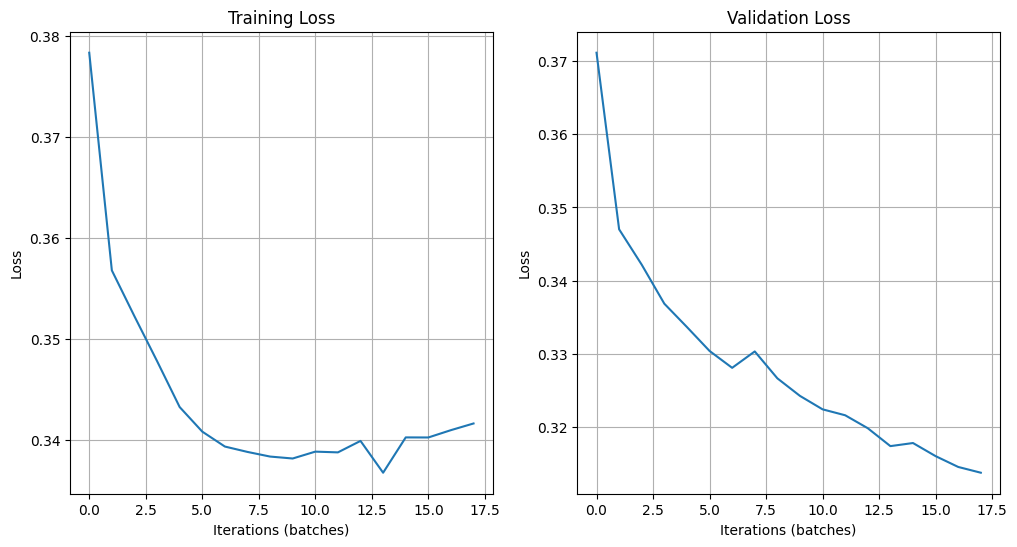

In [181]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(torch.tensor(lossi[:18000]).view(-1, 1000).mean(1))
plt.title('Training Loss')
plt.xlabel('Iterations (batches)')
plt.ylabel('Loss')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(torch.tensor(lossi_val[:18000]).view(-1, 1000).mean(1))
plt.title('Validation Loss')
plt.xlabel('Iterations (batches)')
plt.ylabel('Loss')
plt.grid()

In [182]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [183]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.82260262966156
val 1.9851127862930298


### performance log

- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.918, val 2.027
- flat -> hierarchical (22K params): train 1.941, val 2.029
- fix bug in batchnorm: train 1.912, val 2.022
- scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993


### Exercise:
I beat the model with a train loss of 1.8226, val loss of 1.9851 by using xavier initialization, regularization, ReLU activation, and smaller learning rates. 

In [184]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

kailyn.
kody.
kamari.
essa.
amiyah.
rei.
alysia.
mekary.
jacnayou.
jayziel.
vaiane.
shaiden.
rheera.
ohia.
iyanigh.
keega.
aadhah.
bitty.
mcclanna.
amisora.


### Next time:
Why convolutions? Brief preview/hint

In [ ]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

In [ ]:
# forward a single example:
logits = model(Xtr[[7]])
logits.shape

In [ ]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7+i]])
logits.shape

In [18]:
# convolution is a "for loop"
# allows us to forward Linear layers efficiently over space